In [2]:
import pandas as pd, numpy as np
import re
from os import path
from numpy import mean, std, power, asarray, log

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(context='paper', style='darkgrid', palette="ch:5", font='sans-serif', font_scale=1, color_codes=True, rc=None)

from math import isnan
from numpy import mean, std, power, asarray, log

from scipy import stats
from scipy.stats.mstats import gmean

# Standard plotly imports
# import chart_studio.plotly as py
# import plotly.graph_objs as go
# import plotly.express as px
# from plotly.offline import iplot, init_notebook_mode
# # Using plotly + cufflinks in offline mode
# import cufflinks
# cufflinks.go_offline(connected=True)
# init_notebook_mode(connected=True)

In [3]:
#df housekeeping functions

def rename_columns(df):
    """
    This function renames columns 'Sample Name', 'Gene Name' to 'Sample' and 'Target' respectively.
    :return: Updated df
    :rtype: DataFrame
    """
    df       = df.rename(columns={'Sample Name':'Sample','Gene Name': 'Target', 'Condition Name': 'Treatment'})
    return df

def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

def tidy_df(df, treatment):
    """
    This function performs some rudimentary housekeeping on the raw Lightcycler exported data.
    It removes trailing whitespace in column headers, removes extraneous columns, renames columns as per rename_column, 
    finds and replaces '-' with numeric 0, ensures that the Cq column contain integers,
    and moves the 'Condition Name' column to the end of the df.
    :param DataFrame df: Sample DataFrame
    :param Boolean treatment: If the experiment involved some extra variable such as gravel/non gravel then pass True
    :return: Tidied df
    :rtype: DataFrame
    """
    #Remove whitespace around column headers if any.
    df.rename(columns=lambda x: x.strip(),inplace = True)
    
    df = trim_all_columns(df)
    
    if 'Plate' not in df.columns: df['Plate'] = 'NaN'
    
    #Remove extraneous columns generated by LightCycler export. Columns that are retained are commented out.
    df = df.drop(['Color',
     'Position',
    #  'Sample Name',
    #  'Gene Name',
    #  'Condition Name',
    #  'Cq',
    #  'Cq Mean',
    #  'Cq Error',
     'Excluded',
     'Sample Type',
     'Sample Type RQ',
     'Gene Type',
     'Condition Type',
    #  'Replicate Group',
     'Ratio',
     'Ratio Error',
     'Normalized Ratio',
     'Normalized Ratio Error',
     'Scaled Ratio',
     'Scaled Ratio Error',
     'Dye',
     'Edited Call',
     'Failure',
    #  'Slope',
     'EPF',
     'Notes',
     'Sample Prep Notes',
     'Number'
     #,'Plate'
      ], axis=1)
    
    df       = rename_columns(df)
    df       = df.replace(regex=r'-', value=0)
    df['Cq'] = pd.to_numeric(df['Cq'])
    
    if treatment: df['Treatment'] = df['Treatment'].str.title()
    
    # Add column to define condition
    sample_condition = asarray([re.sub("[^A-Z\d]", "", re.search("^[^_]*", i).group(0).upper()) for i in df['Sample']])
    df['Condition'] = sample_condition
    
#     df.loc[df.Cq > 40, x]= 0
    df['Cq'].where(df['Cq'] < 40, 0, inplace=True)
    
    #change the order of columns
    columns_titles = ['Sample', 'Target', 'Cq', 'Cq Mean', 'Cq Error', 'Replicate Group', 'Slope', 'Condition', 'Treatment', 'Plate']
    df = df[columns_titles]

    return df

In [4]:
# Create DeltaCt column from Ct Mean (e.g. actinCt - targetCt )
# Column for relative expression 2^DeltaCt
# Plot that.

log2 = lambda x: log(x)/log(2)

def average_cq(seq, efficiency=1.0):
    """
    This function converts the Ct values into expression levels, averages them, and
    then converts the average expression levels into average Ct values.
    
    Given a set of Cq values, return the Cq value that represents the
    average expression level of the input.
    The intent is to average the expression levels of the samples,
    since the average of Cq values is not biologically meaningful.
    :param iterable seq: A sequence (e.g. list, array, or Series) of Cq values.
    :param float efficiency: The fractional efficiency of the PCR reaction; i.e.
        1.0 is 100% efficiency, producing 2 copies per amplicon per cycle.
    :return: Cq value representing average expression level
    :rtype: float
    """
#     denominator = sum( [pow(2.0*efficiency, -Ci) for Ci in seq] )
    # Make sure values passed in seq are ints
#     avg_cq = log(len(seq)/denominator)/log(2.0*efficiency)
#     print(seq)
    avg_cq = gmean(seq)
    # TODO return sem and sd as well
    return avg_cq

def sem_cq(seq):
    sem = stats.sem(seq)
    return sem
def sd_cq(seq):
    sd = np.std(seq)
    return sd

def deltacq(seq, efficiency = 1.0):
#     rq_per_sample = [pow(2.0*efficiency, -Ci) for Ci in seq]
    rq_per_sample = seq
    avgcq         = average_cq(seq, efficiency=1.0)
    dcq           = avgcq - rq_per_sample
#     print(rq_per_sample, avgcq, dcq)

list1 = [23.94,23.7,23.48]
# list2 = [17.01,16.84,15.88]
# average_cq(list1)
# deltacq(list1)
# print(gmean(list1), average_cq(list1))


23.705922570474137 23.705922570474137


In [5]:
def rel_expression_ddcq(sample_frame, ref_target):
#     print('Treatment = ',treatment)
    """Calculates expression of samples in a sample data frame relative to a
    single reference gene using the ∆∆Cq method.
    
    :param DataFrame sample_frame: A sample data frame.
    :param string ref_target: A string matching an entry of the Target column;
        the target to use as the reference target (e.g. 'BACTIN')
    :return: A DataFrame with columns: Sample, Target, Age, DeltaCq, and Rel Exp.
    :rtype: DataFrame
    """
    
    if len(sample_frame['Treatment'].unique()) == 1:
        print('Treatment = NaN')
        ref_target_df                = sample_frame.loc[sample_frame['Target'] == ref_target, ['Sample', 'Cq', 'Condition']]
        ref_target_grouped_by_age    = ref_target_df.groupby(['Condition', 'Sample'])
        ref_sample_df_grouped_by_age = sample_frame.groupby(['Condition', 'Sample'])
    else:
        ref_target_df                = sample_frame.loc[sample_frame['Target'] == ref_target, ['Sample', 'Cq', 'Condition', 'Treatment']]
        ref_target_grouped_by_age    = ref_target_df.groupby(['Condition', 'Sample', 'Treatment'])
        ref_sample_df_grouped_by_age = sample_frame.groupby(['Condition', 'Sample', 'Treatment'])
    
    ref_target_stats_by_sample   = ref_target_grouped_by_age['Cq'].aggregate([average_cq, sem_cq, sd_cq])
    
    unique_conditions = sample_frame.Condition.unique()
    sample_dcq_series = []
    new_df = pd.DataFrame({'Sample': [],
                           'Target': [],
                           'Age': [],
                           'DeltaCq': [],
                           'Rel Exp': [],
                           'Treatment': []
                          })


    # Iterates through unique 'conditions' i.e. ages and NEG
    for condition, group in ref_sample_df_grouped_by_age:
        for age in unique_conditions:
            if age == condition[0]:
                sample         = condition[1]
                ref_gene_cq    = ref_target_stats_by_sample.loc[age]['average_cq'][0]
                ref_gene_sd    = ref_target_stats_by_sample.loc[age]['sd_cq'][0]
                
                mean_by_sample = group['Cq'].agg(average_cq)
                sem_by_sample  = sem_cq(group['Cq'])
                sd_by_sample   = sd_cq(group['Cq'])
                
#                 sample_dcq     = mean_by_sample - ref_gene_cq
#                 sample_dcq_sd  = sd_by_sample - ref_gene_sd
#                 rel_exp     = power(2, -sample_dcq)
#                 rel_exp_sd  = power(2, -sample_dcq_sd)
        
                sample_dcq     = ref_gene_cq - mean_by_sample
                sample_dcq_sd  = ref_gene_sd - sd_by_sample
                
                rel_exp     = power(2, sample_dcq)
                rel_exp_sd  = power(2, sample_dcq_sd)
#                 rel_exp needs to be sample_dcq - ref_gene_dcq?

#                 print(sample, sample_dcq, rel_exp)
                new_df = new_df.append({'Sample': sample,
                           'Target': group['Target'].unique()[0],
                           'Age': age,
                           'DeltaCq': sample_dcq,
                           'Rel Exp': rel_exp,
                           'Rel Exp SD': rel_exp_sd,
                           'Treatment': group['Treatment'].unique()[0]}
                             ,ignore_index=True)               
    
#     new_df.to_csv(path+fname+'_analysed.csv', index = None, header=True)
    return new_df


# testdf          = df
# print(df)
# df_relexp       = rel_expression_ddcq(testdf, 'GRIN1A')
# df_exclude_negs = df_relexp.loc[(df_relexp['Target'] != 'BACTIN') & (df_relexp['Condition'] != 'NEG')]

# norm to bacin then grin1a?

In [6]:
path  = "../191122_qPCR/"
fname = "191122_WT58_GRIN"

file  = path+fname+'.csv'
df    = tidy_df(pd.read_csv(file, header=0),False)

df_relexp       = rel_expression_ddcq(df, 'GRIN1A')
df_exclude_negs = df_relexp.loc[(df_relexp['Target'] != 'BACTIN') & (df_relexp['Age'] != 'NEG')]
df_zoom = df_exclude_negs.loc[(df_exclude_negs['Target'] != 'GRIN1A') & (df_exclude_negs['Target'] != 'GRIN1B')]

sns.set(context='paper', style='whitegrid', palette="ch:2.5,-.2,dark=.3", font='sans-serif', font_scale=2, color_codes=True, rc=None)

g = sns.catplot(x="Target", y="Rel Exp", hue='Age', data=df_exclude_negs, saturation=.5, kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Relative Expression").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB"],rotation=45).set_titles("{col_name}").despine(left=True))

h = sns.catplot(x="Target", y="Rel Exp", hue='Age', data=df_zoom, saturation=.5, kind="bar", ci=None, aspect=.6)
(h.set_axis_labels("", "Relative Expression").set_xticklabels(["2AA", "2AB", "2BA", "2BB"],rotation=45).set_titles("{col_name}").despine(left=True))

Treatment = NaN


/Users/jade/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:305: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


IndexError: tuple index out of range

In [7]:
path  = "../Windows7Files/experiments/LightCyclerMakeyev/191122_qPCR/"
fname = "191122_WT58_GRIN"

file  = path+fname+'.csv'
df    = tidy_df(pd.read_csv(file, header=0),False)

df_relexp       = rel_expression_ddcq(df, 'BACTIN')
df_exclude_negs = df_relexp.loc[(df_relexp['Target'] != 'BACTIN') & (df_relexp['Age'] != 'NEG')]
df_zoom = df_exclude_negs.loc[(df_exclude_negs['Target'] != 'GRIN1A') & (df_exclude_negs['Target'] != 'GRIN1B')]

sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)


g = sns.catplot(x="Target", y="Rel Exp", hue='Age', data=df_exclude_negs, saturation=.5, kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Relative Expression").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB"], rotation=45).set_titles("{col_name}").despine(left=True))

h = sns.catplot(x="Target", y="Rel Exp", hue='Age', data=df_zoom, saturation=.5, kind="bar", ci=None, aspect=.6)
(h.set_axis_labels("", "Relative Expression").set_xticklabels(["2AA", "2AB", "2BA", "2BB"], rotation=45).set_titles("{col_name}").despine(left=True))

# i = sns.lineplot(x="Age", y="Rel Exp", hue='Target', palette="ch:2.5,.25", data=df_zoom)


FileNotFoundError: File b'../Windows7Files/experiments/LightCyclerMakeyev/191122_qPCR/191122_WT58_GRIN.csv' does not exist

In [8]:
i = sns.lineplot(x="Age", y="Rel Exp", hue='Target', palette="ch:2.5,.25", data=df_zoom)

NameError: name 'df_zoom' is not defined

In [9]:
df_relexp

NameError: name 'df_relexp' is not defined

In [10]:
path      = "../Analyses/200117_qPCR/"
fname_pt1 = "200117_WT58_gravel_non_gravel_pt1"
fname_pt2 = "200117_WT58_gravel_non_gravel_pt2"
file_pt1  = path+fname_pt1+'.csv'
file_pt2  = path+fname_pt2+'.csv'
df_pt1    = pd.read_csv(file_pt1, header=0)
df_pt2    = pd.read_csv(file_pt2, header=0)

analysed_df_pt1 = rel_expression_ddcq(tidy_df(df_pt1, True), 'BACTIN')
analysed_df_pt2 = rel_expression_ddcq(tidy_df(df_pt2, True), 'BACTIN')
df_concat       = pd.concat([analysed_df_pt1,analysed_df_pt2])

[(df_concat['Target'] != 'BACTIN') & (df_concat['Age'] != 'NEG')]

df_concat_exclude_negs = df_concat.loc[(df_concat['Target'] != 'BACTIN') & (df_concat['Age'] != 'NEG')]


df      = df_concat_exclude_negs.sort_values(['Target','Age','Treatment']).reset_index(drop=True)
df_zoom = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]

sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

g = sns.catplot(x="Target", y="Rel Exp", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df, saturation=.5, kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Relative Expression").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB"], rotation=45).set_titles("{col_name}").despine(left=True))

h = sns.catplot(x="Target", y="Rel Exp", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df_zoom, saturation=.5, kind="bar", ci=None, aspect=.6)
(h.set_axis_labels("", "Relative Expression").set_xticklabels(["2AA", "2AB", "2BA", "2BB"], rotation=45).set_titles("{col_name}").despine(left=True))



FileNotFoundError: File b'../Analyses/200117_qPCR/200117_WT58_gravel_non_gravel_pt1.csv' does not exist

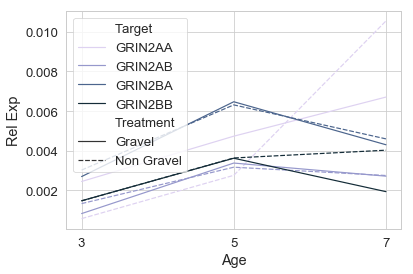

In [164]:
i = sns.lineplot(x="Age", y="Rel Exp", hue='Target', style='Treatment', palette="ch:2.5,.25", data=df_zoom)

In [29]:
path      = "../Analyses/200117_qPCR/"
fname_pt1 = "200117_WT58_gravel_non_gravel_pt1"
fname_pt2 = "200117_WT58_gravel_non_gravel_pt2"
file_pt1  = path+fname_pt1+'.csv'
file_pt2  = path+fname_pt2+'.csv'
df_pt1    = pd.read_csv(file_pt1, header=0)
df_pt2    = pd.read_csv(file_pt2, header=0)

df_pt1['Plate'] = '1'
df_pt2['Plate'] = '2'

raw_df_concat = tidy_df(pd.concat([df_pt1,df_pt2]), treatment=True)
raw_df_concat

FileNotFoundError: File b'../Analyses/200117_qPCR/200117_WT58_gravel_non_gravel_pt1.csv' does not exist

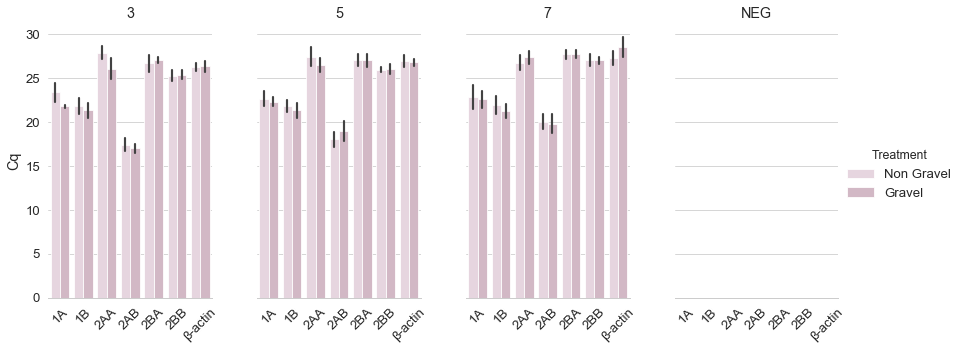

In [108]:
sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

g = sns.catplot(x="Target", y="Cq", col="Condition", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=raw_df_concat, saturation=.5, kind="bar", ci='sd', aspect=.6)
(g.set_axis_labels("", "Cq").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))
#make y axis log

In [28]:
path      = "../../Analyses/200129_qPCR/"
fname_pt1 = "200129_WT58_gravel_non_gravel_pt1"
fname_pt2 = "200129_WT58_gravel_non_gravel_pt2"
file_pt1  = path+fname_pt1+'.csv'
file_pt2  = path+fname_pt2+'.csv'
df_pt1    = pd.read_csv(file_pt1, header=0)
df_pt2    = pd.read_csv(file_pt2, header=0)

df_pt1['Plate'] = '1'
df_pt2['Plate'] = '2'

raw_df_concat = tidy_df(pd.concat([df_pt1,df_pt2]), treatment=True)

sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

g = sns.catplot(x="Target", y="Cq", col="Condition", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=raw_df_concat, saturation=.5, kind="bar", ci='sd', aspect=.6)
(g.set_axis_labels("", "Cq").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))
# make y axis log

/Users/jade/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':


TypeError: expected string or bytes-like object

In [14]:
bactin_only_df = raw_df_concat.loc[raw_df_concat['Target'] == 'BACTIN']

sns.set(context='paper', style='whitegrid', palette="ch:9.2,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

g = sns.catplot(x="Sample", y="Cq", hue='Plate', hue_order=['1','2'], data=bactin_only_df, saturation=.5, kind="bar", ci='sd', aspect=.6)
(g.set_axis_labels("", "Cq").set_xticklabels(["3", "5", "7"], rotation=45).set_titles("{col_name}").despine(left=True))

h = sns.catplot(x="Sample", y="Cq", col='Plate', hue='Treatment', hue_order=['Non Gravel','Gravel'], data=bactin_only_df, saturation=.5, kind="bar", ci='sd', aspect=.6)
(h.set_axis_labels("", "Cq").set_xticklabels(["3", "5", "7"], rotation=45).set_titles("{col_name}").despine(left=True))

NameError: name 'raw_df_concat' is not defined

In [120]:
path      = "../Analyses/200117_qPCR/"
fname_pt1 = "200117_WT58_gravel_non_gravel_pt1"
fname_pt2 = "200117_WT58_gravel_non_gravel_pt2"
file_pt1  = path+fname_pt1+'.csv'
file_pt2  = path+fname_pt2+'.csv'
df_pt1    = pd.read_csv(file_pt1, header=0)
df_pt2    = pd.read_csv(file_pt2, header=0)

# analysed_df_pt1 = rel_expression_ddcq(tidy_df(df_pt1, True), 'GRIN1A')
# analysed_df_pt2 = rel_expression_ddcq(tidy_df(df_pt2, True), 'GRIN1A')
# df_concat       = pd.concat([analysed_df_pt1,analysed_df_pt2])

# [(df_concat['Target'] != 'BACTIN') & (df_concat['Age'] != 'NEG')]

# df_concat_exclude_negs = df_concat.loc[(df_concat['Target'] != 'BACTIN') & (df_concat['Age'] != 'NEG')]


# df      = df_concat_exclude_negs.sort_values(['Target','Age','Treatment']).reset_index(drop=True)
# df_zoom = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]

# sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

# g = sns.catplot(x="Target", y="Rel Exp", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df, saturation=.5, kind="bar", ci=None, aspect=.6)
# (g.set_axis_labels("", "Relative Expression").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB"], rotation=45).set_titles("{col_name}").despine(left=True))

# h = sns.catplot(x="Target", y="Rel Exp", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df_zoom, saturation=.5, kind="bar", ci=None, aspect=.6)
# (h.set_axis_labels("", "Relative Expression").set_xticklabels(["2AA", "2AB", "2BA", "2BB"], rotation=45).set_titles("{col_name}").despine(left=True))
analysed_df_pt1



,Sample,Target,Age,DeltaCq,Rel Exp,Treatment,Rel Exp SD
0,3_1A,GRIN1A,3,0.000000,1.000000,Gravel,1.000000
1,3_1A,GRIN1A,3,1.200180,0.435221,Non Gravel,0.520428
2,3_1B,GRIN1B,3,-0.694368,1.618176,Gravel,0.623273
3,3_1B,GRIN1B,3,-0.288266,1.221172,Non Gravel,0.599240
4,3_2AA,GRIN2AA,3,3.864827,0.068639,Gravel,0.487712
5,3_2AA,GRIN2AA,3,5.956842,0.016099,Non Gravel,0.698604
6,3_BACTIN,BACTIN,3,-4.809602,28.043646,Gravel,0.836194
7,3_BACTIN,BACTIN,3,-4.568982,23.735624,Non Gravel,0.593542
8,5_1A,GRIN1A,5,0.000000,1.000000,Gravel,1.000000
9,5_1A,GRIN1A,5,0.220379,0.858340,Non Gravel,0.793501


In [ ]:
# data      = df[['Target', 'Rel Exp', 'Treatment', 'Age']].groupby(['Treatment', 'Age'])
data      = df[['Target', 'Rel Exp', 'Treatment', 'Age']].groupby('Age')


# data = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]
# data = data[['Target', 'Rel Exp', 'Treatment', 'Age']].groupby(['Treatment', 'Age'])

# gravel3    = data.get_group(('Gravel','3'))
# nongravel3 = data.get_group(('Non Gravel', '3'))

# gravel5    = data.get_group(('Gravel','5'))
# nongravel5 = data.get_group(('Non Gravel', '5'))

# gravel7    = data.get_group(('Gravel','7'))
# nongravel7 = data.get_group(('Non Gravel', '7'))

gravel3    = data.get_group('3')
gravel5    = data.get_group('5')
gravel7    = data.get_group('7')



barWidth   = 0.25

x = np.arange(len(gravel3['Target'])) - 0.13
colorg, colorng = '#78dea7', '#4e9670'
a3, a5, a7 = 0.8, 0.9, 1


fig, ax = plt.subplots(1,3,figsize=(12,5), sharey=True)
labels = df['Target'].unique()
plt.setp(ax, xticks=x, xticklabels=labels)

ax[0].bar(x, gravel3['Rel Exp'], color=colorg, alpha=a3, width=barWidth, edgecolor='white', label='Gravel')
ax[0].bar(x+0.25, nongravel3['Rel Exp'], color=colorng, alpha=a3, width=barWidth, edgecolor='white', label='Non Gravel')

ax[1].bar(x, gravel5['Rel Exp'], color=colorg, alpha=a5, width=barWidth, edgecolor='white', label='Gravel')
ax[1].bar(x+0.25, nongravel5['Rel Exp'], color=colorng, alpha=a5, width=barWidth, edgecolor='white', label='Non Gravel')


ax[2].bar(x, gravel7['Rel Exp'], color=colorg, alpha=a7, width=barWidth, edgecolor='white', label='Gravel')
ax[2].bar(x+0.25, nongravel7['Rel Exp'], color=colorng, alpha=a7, width=barWidth, edgecolor='white', label='Non Gravel')

# ax.set_xticks(labels, minor=False)

ax[2].legend()
plt.show()


In [ ]:
sns.set(context='paper', style='darkgrid', palette="ch:2.5,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

# df        = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]
data      = df[['Target', 'Rel Exp', 'Treatment', 'Age']].groupby('Age')


gravel3    = data.get_group('3')
gravel5    = data.get_group('5')
gravel7    = data.get_group('7')


fig, ax = plt.subplots(1,3,figsize=(12,5), constrained_layout=True, sharey=True)

sns.catplot(x='Target', y='Rel Exp', hue='Treatment', ci='sd', kind='bar', data=gravel3, ax=ax[0])
ax[0].set_xticklabels(ax[0].xaxis.get_majorticklabels(), rotation=50)

sns.catplot(x='Target', y='Rel Exp', hue='Treatment', ci='sd', kind='bar', data=gravel5, ax=ax[1])
ax[1].set_xticklabels(ax[1].xaxis.get_majorticklabels(), rotation=50)

sns.catplot(x='Target', y='Rel Exp', hue='Treatment', ci='sd', kind='bar', data=gravel7, ax=ax[2])
ax[2].set_xticklabels(ax[2].xaxis.get_majorticklabels(), rotation=50)


# ax[1].bar(x, gravel5['Rel Exp'], color=colorg, alpha=a5, width=barWidth, edgecolor='white', label='Gravel')
# ax[1].bar(x+0.25, nongravel5['Rel Exp'], color=colorng, alpha=a5, width=barWidth, edgecolor='white', label='Non Gravel')


# ax[2].bar(x, gravel7['Rel Exp'], color=colorg, alpha=a7, width=barWidth, edgecolor='white', label='Gravel')
# ax[2].bar(x+0.25, nongravel7['Rel Exp'], color=colorng, alpha=a7, width=barWidth, edgecolor='white', label='Non Gravel')

plt.close(2)
plt.close(3)
plt.close(4)


plt.show()



In [ ]:
sns.set(context='paper', style='darkgrid', palette="ch:2.5,-.2,dark=.3", font='sans-serif', font_scale=2, color_codes=True, rc=None)

df            = df_exclude_negs.sort_values(['Target','Age']).reset_index(drop=True)
df_no_1A_1B   = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]

fig, ax = plt.subplots(1,2, figsize=(18,9)c)
fig.suptitle('Normalised to B-Actin', fontsize=25)
sns.catplot(x='Target', y='Rel Exp', hue='Age', ci='sd', kind='bar', data=df, ax=ax[0])
sns.catplot(x='Target', y='Rel Exp', hue='Age', ci='sd', kind='bar', data=df_no_1A_1B, ax=ax[1])

plt.close(2)
plt.close(3)


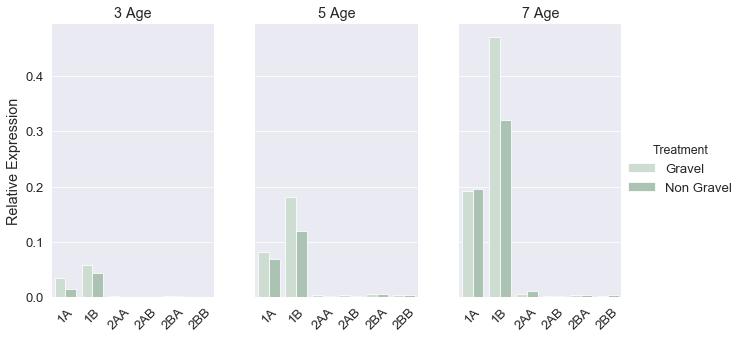

In [315]:
g = sns.catplot(x="Target", y="Rel Exp", col="Age", hue='Treatment', data=df, saturation=.5, kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Relative Expression").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB"], rotation=45).set_titles("{col_name} {col_var}").despine(left=True))

In [33]:
import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()